**import dependencies**

In [11]:
import numpy as np
import cv2

import PIL
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from google.colab import files

**Initialise shape of image**

In [12]:
IMAGE_SHAPE = (224,224)

**Select a pre-trained model** 
Note: this section need not run. It's for testing the use of the selected model.
Instructions (**if haven't done so**):
1. Upload a random picture of a toucan from online (save as: "toucan.jpg")
2. Upload a random picture of an earthstar from online (save as: "earthstar.jpg")
3. Upload the labels txt file the model was trained on. [file](https://download.tensorflow.org/data/ImageNetLabels.txt)

Model should successfully predict the uploaded images to be toucan and earthstar accordingly

In [ ]:

classifier = tf.keras.models.Sequential([
                                         # with a depth multiplier of 1.0 and an input size of 224x224 pixels
                                         hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE + (3,))
])

files.upload()

earthstar = PIL.Image.open('earthstar.jpg').resize(IMAGE_SHAPE)
toucan = PIL.Image.open('toucan.jpg').resize(IMAGE_SHAPE)
earthstar = np.array(earthstar)/255.0
toucan = np.array(toucan)/255.0

# earthstar[np.newaxis, ...]

result_earthstar = classifier.predict(earthstar[np.newaxis, ...]) # classifier expects an array of images (in numpy form) as input 
result_toucan = classifier.predict(toucan[np.newaxis, ...])
predicted_label_earthstar = np.argmax(result_earthstar)
predicted_label_toucan = np.argmax(result_toucan)

image_labels = []
with open('ImageNetLabels.txt', 'r') as f:
  image_labels = f.read().splitlines()
# image_labels[:10] # observe what this line does

print("Predicted results for earthstar: " + image_labels[predicted_label_earthstar])
print("Predicted results for toucan: " + image_labels[predicted_label_toucan])

Predicted results for earthstar: earthstar
Predicted results for toucan: toucan


**Dataset of flowers to apply transfer learning upon**

In [13]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file("flower_photos", origin=dataset_url, cache_dir='.', untar=True)

**Separate images based on featured flower**

In [14]:
import pathlib
data_dir = pathlib.Path(data_dir)
flowers_images = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*'))
}

In [15]:
flower_labels = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4
}

**Resize images**

In [16]:
X, y = [], []
for flower_name, images in flowers_images.items():
  for image in images:
    img = cv2.imread(str(image))
    resized = cv2.resize(img, IMAGE_SHAPE)
    X.append(resized)
    y.append(flower_labels[flower_name])

In [17]:
X = np.array(X)
y = np.array(y)
X = X/255


**Obtain test and train data**

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

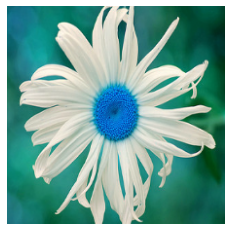

In [ ]:
plt.axis('off')
plt.imshow(X[777])

**Apply TL**



In [19]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
pretrained_model = hub.KerasLayer(
    feature_extractor_model, input_shape = (224,224,3), trainable=False)

cnn_tl = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(5)
])
cnn_tl.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

cnn_tl.fit(X_train, y_train, epochs = 5)



Epoch 1/5
86/86 [==============================] - 107s 1s/step - loss: 0.7985 - acc: 0.6930
Epoch 2/5
86/86 [==============================] - 98s 1s/step - loss: 0.4128 - acc: 0.8590
Epoch 3/5
86/86 [==============================] - 103s 1s/step - loss: 0.3209 - acc: 0.8993
Epoch 4/5
86/86 [==============================] - 99s 1s/step - loss: 0.2730 - acc: 0.9157
Epoch 5/5
86/86 [==============================] - 99s 1s/step - loss: 0.2351 - acc: 0.9306


In [ ]:
cnn_tl.evaluate(X_test, y_test)